# Histograms
This notebook demonstrates simple use of histograms in sn.

### Set up libraries and load exemplar dataset

In [1]:
# load libraries
import os
import opendp.smartnoise.core as sn
import numpy as np
import math
import statistics

# establish data information
data_path = os.path.join('.', 'data', 'grocery_customers', 'data.csv')
var_names = ["ID", "Year_Birth", "Education", "Marital_Status", "Income", "Kidhome", "Teenhome",
            "Dt_Customer", "Recency", "MntWines", "MntFuits", "MntMeatProducts", "MntFishProducts", 
            "MntSweetProducts", "MntGoldProds", "NumDealsPurchases", "NumWebPurchases", 
            "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth" ]

data = np.genfromtxt(data_path, delimiter='\t', names=True)

#remove empty rows
data = data[~np.isnan(data["Income"])]
age = list(2021 - data[:]['Year_Birth'])

print("Dimension of dataset: " + str(data.shape))
print("Names of variables:   " + str(data.dtype.names))

Dimension of dataset: (2216,)
Names of variables:   ('ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth')


### Creating DP Releases of Histograms

The default method for generating a histogram in SmartNoise is by releasing counts of each bin or category using the geometric mechanism.  The geometric mechanism only returns integer values for any query, so resists some vulnerabilities of DP releases from floating point approximations (see Mironov 2012).  It is also possible, however, to generate histograms from the more typical Laplace mechanism, if `protect_floating_point` is disabled.  We show both approaches below.

Here we generate histograms on three types of variables:
* A continuous variable, here `income`, where the set of numbers have to be divided into bins,
* A boolean or dichotomous variable, here `sex`, that can only take on two values,
* A categorical variable, here `education`, where there are distinct categories enumerated as strings.

Note the education variable is coded in the data on a scale from 1 to 16, but we're leaving the coded values as strings throughout this notebook.

In [48]:
income_edges = list(range(0, 100000, 10000))
education_categories = ["2n Cycle", "Graduation", "Master", "PhD", "Basic" ]


with sn.Analysis(protect_floating_point=False) as analysis:
    data = sn.Dataset(path = data_path, column_names = var_names)
    nsize = 2216    
        
    income_histogram = sn.dp_histogram(
            sn.to_int(data['Income'], lower=0, upper=100000),
            edges = income_edges,
            upper = nsize,
            null_value = -1,
            privacy_usage = {'epsilon': 0.5}
        )

    income_prep = sn.histogram(sn.to_int(data['Income'], lower=0, upper=100000),
                                     edges=income_edges, null_value =-1)
    income_histogram2 = sn.laplace_mechanism(income_prep, privacy_usage={"epsilon": 0.5, "delta": .0001})
    
    
    #sex_histogram = sn.dp_histogram(
    #        sn.to_bool(data['sex'], true_label="0"),
    #        upper = nsize,
    #        privacy_usage = {'epsilon': 0.5}
    #    )
    
    #sex_prep = sn.histogram(sn.to_bool(data['sex'], true_label="0"), null_value = True)
    #sex_histogram2 = sn.laplace_mechanism(sex_prep, privacy_usage={"epsilon": 0.5, "delta": .000001})
    
    education_histogram = sn.dp_histogram(
            data['Education'],
            categories = education_categories,
            null_value = "-1",
            privacy_usage = {'epsilon': 0.5}
        )

    education_prep = sn.histogram(data['Education'],
            categories = education_categories, null_value = "-1")
    education_histogram2 = sn.laplace_mechanism(education_prep, privacy_usage={"epsilon": 0.5, "delta": .000001})
    

analysis.release()

print("Income histogram Geometric DP release:   " + str(income_histogram.value))
print("Income histogram Laplace DP release:     " + str(income_histogram2.value))

#print("Sex histogram Geometric DP release:      " + str(sex_histogram.value))
#print("Sex histogram Laplace DP release:        " + str(sex_histogram2.value))

print("Education histogram Geometric DP release:" + str(education_histogram.value))
print("Education histogram Laplace DP release:  " + str(education_histogram2.value))

Income histogram Geometric DP release:   [214 217 214 230 227 214 214 273 212 237]
Income histogram Laplace DP release:     [229.84826428 216.09555874 233.10741152 242.24708743 195.03233147
 218.98910581 228.09424748 215.81637859 235.19537226 230.02837409]
Education histogram Geometric DP release:[   1    0    0    0    0 2239]
Education histogram Laplace DP release:  [ 1.84887761e+00  3.16528568e+00 -4.28276320e+00 -3.58610863e+00
 -1.07755855e+01  2.24457731e+03]


We can see most obviously that the releases from the Geometric mechanism are integer counts, while the Laplace releases are floating point numbers.

Below, we will quickly create histograms of the actual private data, for a point of comparison to our differentially private releases:

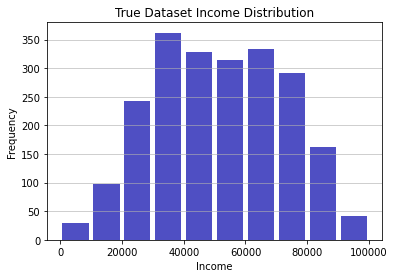

In [52]:
import matplotlib.pyplot as plt

data = np.genfromtxt(data_path, delimiter='\t', names=True)
income = list(data[:]['Income'])
#sex = list(data[:]['sex'])
education = list(data[:]['Education'])

# An "interface" to matplotlib.axes.Axes.hist() method
n_income, bins, patches = plt.hist(income, bins=list(range(0,110000,10000)), color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('True Dataset Income Distribution')
plt.show()

#n_sex, bins, patches = plt.hist(sex, bins=[-0.5,0.5,1.5], color='#0504aa',
#                            alpha=0.7, rwidth=0.85)
#plt.grid(axis='y', alpha=0.75)
#plt.xlabel('Sex')
#plt.ylabel('Frequency')
#plt.title('True Dataset Sex Distribution')
#plt.show()
#!pip3 install warnings
#import warnings
#dealing with bug https://stackoverflow.com/questions/40659212/futurewarning-elementwise-comparison-failed-returning-scalar-but-in-the-futur
#with warnings.catch_warnings():
#    warnings.simplefilter(action='ignore', category=FutureWarning)


#print(data[1])
#count_arr = np.bincount(education)
#print(count_arrs)
# Count occurrence of element '3' in numpy array
#print('Total occurences of "Master" in array: ', count_arr["Master"])

#data = {"Basic": np.count_nonzero(data["Education"] == "Basic"),
#    "2n cycle": np.count_nonzero(data["Education"] == "2n Cycle"),
#    "Graduation": np.count_nonzero(data["Education"] == "Graduation"),
#    "Master": np.count_nonzero(data["Education"] == "Master"),
#    "PhD": np.count_nonzero(data["Education"] == "PhD")}
#names = list(data.keys())
#values = list(data.values())

#fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
#axs[0].bar(names, values)
#axs[1].scatter(names, values)
#axs[2].plot(names, values)
#fig.suptitle('Categorical Plotting')
#plt.show()

#n_educ, bins, patches = plt.hist(education, bins=list(range(1,19,1)), color='#0504aa',alpha=0.7, rwidth=0.85)
#plt.xticks(list(range(0,5,1)), ["2n cycle", "Master", "PhD", "Graduation", "Basic"])
#n_educ, patches = plt.hist(education, color='#0504aa')
#plt.grid(axis='y', alpha=0.75)
#plt.xlabel('Education')
#plt.ylabel('Frequency')
#plt.title('True Dataset Education Distribution')
#plt.show()

Below we can see the differentially private releases of these variables in shades of red, against the "true" private counts in green.

[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]
[ 29.  98. 243. 362. 328. 314. 334. 291. 163.  41.]
[214 217 214 230 227 214 214 273 212 237]
[229.84826428 216.09555874 233.10741152 242.24708743 195.03233147
 218.98910581 228.09424748 215.81637859 235.19537226 230.02837409]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

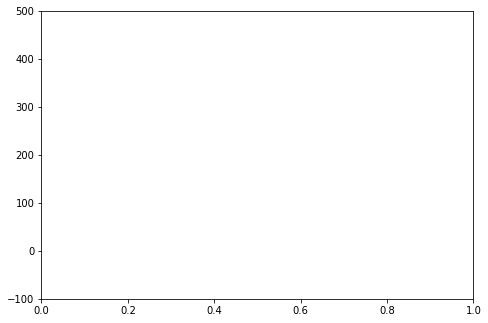

In [53]:
import matplotlib.pyplot as plt

colorseq = ["forestgreen", "indianred", "orange", "orangered", "orchid"]

print(list(range(0,100000,10000)))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim([-100,500])
#inccat = ["10k","20k","30k","40k","50k","60k","70k","80k","90k","100k"]
inccat = [10,20,30,40,50,60,70,80,90]
width=3
print(n_income)
print(income_histogram.value)
print(income_histogram2.value)
inccat_left = [x + width for x in inccat]
inccat_right = [x + 2*width for x in inccat]
ax.bar(inccat, n_income, width=width, color=colorseq[0], label='True Value')
ax.bar(inccat_left, income_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
ax.bar(inccat_right, income_histogram2.value.astype(int), width=width, color=colorseq[2], label='DP Laplace')
ax.legend()
plt.title('Histogram of Income')
plt.xlabel('Income, in thousands')
plt.ylabel('Count')
plt.show()



#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#plt.ylim([0,800])
#sexcat = [0,1]
#width = 0.2
#sexcat_left = [x + width for x in sexcat]
#sexcat_right = [x + 2*width for x in sexcat]
#ax.bar(sexcat, n_sex, width=width, color=colorseq[0], label='True Value')
#ax.bar(sexcat_left, sex_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
#ax.bar(sexcat_right, sex_histogram2.value, width=width, color=colorseq[2], label='DP Laplace')
#ax.legend()
#plt.title('Histogram of Sex')
#plt.ylabel('Count')
#plt.show()


#fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
#edcat = list(range(1,18))
#width = 0.25
#edcat_left = [x + width for x in edcat]
#edcat_right = [x + 2*width for x in edcat]
#ax.bar(edcat, n_educ, width=width, color=colorseq[0], label='True Value')
#ax.bar(edcat_left, education_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
#ax.bar(edcat_right, education_histogram2.value, width=width, color=colorseq[2], label='DP Laplace')
#ax.legend()
#plt.title('Histogram of Education')
#plt.xlabel('Educational Attainment Category')
#plt.ylabel('Count')
#plt.show()


## References

Mironov, Ilya. "On significance of the least significant bits for differential privacy." In Proceedings of the 2012 ACM conference on Computer and communications security, pp. 650-661. 2012.